In [102]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [103]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [105]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 541, Edges: 35711

 Node types:
  default: [541]
    Features: float32 vector, length 500
    Edge types: default-default->default

 Edge types:
    default-default->default: [35711]
        Weights: range=[0.960001, 0.99577], mean=0.967045, std=0.00527737
        Features: none


In [138]:
# Splitting data into train/validation/test

train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

series_classes = df_classes['class']
series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  405
Len validation:  54
Len test:  82

Len everything:  541


In [139]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'control': 53,
         'stage2': 37,
         'stage1': 181,
         'stage3': 82,
         'stage4': 52})

In [140]:
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))

array(['control', 'stage1', 'stage2', 'stage3', 'stage4'], dtype='<U7')

In [142]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.52830189, 0.44751381, 2.18918919, 0.98780488, 1.55769231])

## The code below is used to downsample the training data. Skip it if this is not the goal

In [123]:
# Testar downsample na train_subjects
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)

Counter({'stage1': 50,
         'stage2': 37,
         'stage3': 50,
         'stage4': 50,
         'control': 50})

In [143]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [144]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [155]:
gat = GAT(
    layer_sizes=[100, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=4,
    generator=generator,
    in_dropout=0.1,
    attn_dropout=0.1,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [151]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        cast(y_true, dtype=int64)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [156]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(weights),
    metrics=["acc"],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [157]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 2s - loss: 6.1519 - acc: 0.1728 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 2/500
1/1 - 0s - loss: 8.9539 - acc: 0.4444 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 3/500
1/1 - 0s - loss: 8.8404 - acc: 0.4494 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 4/500
1/1 - 0s - loss: 8.8274 - acc: 0.4494 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 5/500
1/1 - 0s - loss: 8.8165 - acc: 0.4494 - val_loss: 8.4185 - val_acc: 0.4630
Epoch 6/500
1/1 - 0s - loss: 7.2408 - acc: 0.5432 - val_loss: 7.1636 - val_acc: 0.5556
Epoch 7/500
1/1 - 0s - loss: 8.5330 - acc: 0.4370 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 8/500
1/1 - 0s - loss: 7.2855 - acc: 0.5383 - val_loss: 8.8968 - val_acc: 0.4444
Epoch 9/500
1/1 - 0s - loss: 8.1754 - acc: 0.4840 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 10/500
1/1 - 0s - loss: 8.3298 - acc: 0.4741 - val_loss: 8.6873 - val_acc: 0.4444
Epoch 11/500
1/1 - 0s - loss: 8.3308 - acc: 0.4815 - val_loss: 7.6469 - val_acc: 0.4815
Epoch 12/500
1/1 - 0s - loss: 7.5309 - ac

Epoch 95/500
1/1 - 0s - loss: 7.3626 - acc: 0.5432 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 96/500
1/1 - 0s - loss: 7.2034 - acc: 0.5531 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 97/500
1/1 - 0s - loss: 7.3959 - acc: 0.5407 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 98/500
1/1 - 0s - loss: 7.2034 - acc: 0.5531 - val_loss: 7.4630 - val_acc: 0.5370
Epoch 99/500
1/1 - 0s - loss: 7.2432 - acc: 0.5506 - val_loss: 7.4897 - val_acc: 0.5000
Epoch 100/500
1/1 - 0s - loss: 7.3228 - acc: 0.5457 - val_loss: 7.5952 - val_acc: 0.5000
Epoch 101/500
1/1 - 0s - loss: 7.2432 - acc: 0.5506 - val_loss: 7.7103 - val_acc: 0.5000
Epoch 102/500
1/1 - 0s - loss: 7.0581 - acc: 0.5605 - val_loss: 7.5008 - val_acc: 0.5000
Epoch 103/500
1/1 - 0s - loss: 7.0840 - acc: 0.5605 - val_loss: 7.4624 - val_acc: 0.5370
Epoch 104/500
1/1 - 0s - loss: 7.1636 - acc: 0.5556 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 105/500
1/1 - 0s - loss: 7.2432 - acc: 0.5506 - val_loss: 7.4621 - val_acc: 0.5370
Epoch 106/500
1/1 - 0s - l

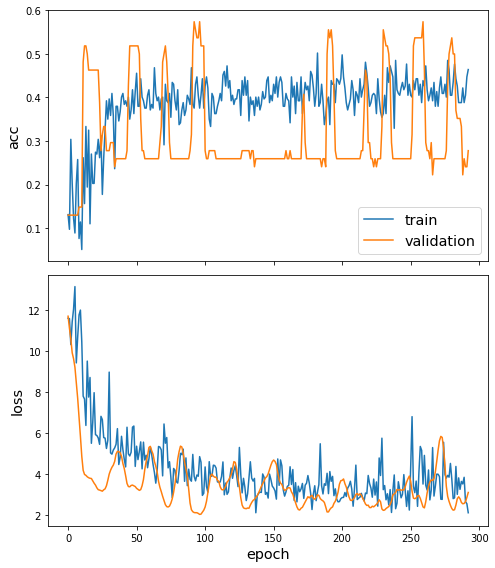

In [132]:
sg.utils.plot_history(history)

In [133]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 65ms/step - loss: 1.8425 - acc: 0.5488

Test Set Metrics:
	loss: 1.8425
	acc: 0.5488


In [118]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [119]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})
df['Predicted'].value_counts()

stage1     369
control     71
stage3      63
stage4      38
Name: Predicted, dtype: int64

In [120]:
G.check_graph_for_ml()

In [121]:
for component in G.connected_components():
    print(len(component))

530
3
2
2
2
2


In [122]:
G.node_degrees()

defaultdict(int,
            {'TCGA.3Z.A93Z.01': 171,
             'TCGA.A3.3306.01': 8,
             'TCGA.A3.3307.01': 281,
             'TCGA.A3.3308.01': 132,
             'TCGA.A3.3311.01': 302,
             'TCGA.A3.3316.01': 54,
             'TCGA.A3.3317.01': 50,
             'TCGA.A3.3319.01': 1,
             'TCGA.A3.3320.01': 206,
             'TCGA.A3.3322.01': 221,
             'TCGA.A3.3323.01': 156,
             'TCGA.A3.3324.01': 249,
             'TCGA.A3.3325.01': 262,
             'TCGA.A3.3326.01': 225,
             'TCGA.A3.3329.01': 262,
             'TCGA.A3.3331.01': 256,
             'TCGA.A3.3335.01': 18,
             'TCGA.A3.3343.01': 243,
             'TCGA.A3.3347.01': 31,
             'TCGA.A3.3349.01': 250,
             'TCGA.A3.3351.01': 182,
             'TCGA.A3.3352.01': 206,
             'TCGA.A3.3357.01': 51,
             'TCGA.A3.3358.11': 42,
             'TCGA.A3.3358.01': 277,
             'TCGA.A3.3359.01': 246,
             'TCGA.A3.3362.01':

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

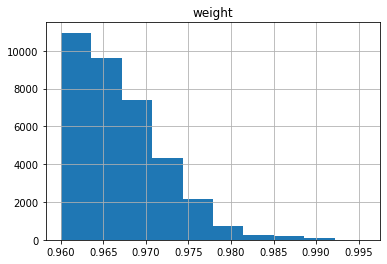

In [100]:
df_patients.hist(column='weight')

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

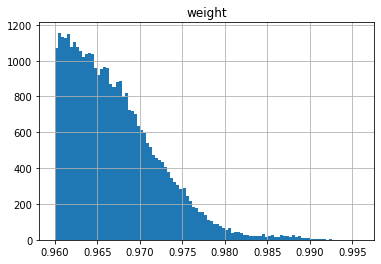

In [101]:
df_patients.hist(column='weight', bins=100)

<AxesSubplot:ylabel='Density'>

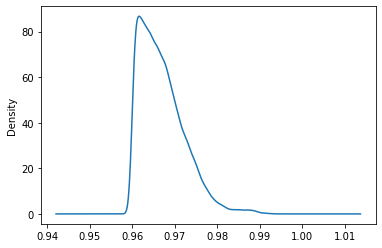

In [102]:
df_patients['weight'].plot.kde()